In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.append('../../')

In [2]:
from pyexp.transform.fracdiff import fracdiff

setattr(pd.Series, 'fracdiff', fracdiff)

## Motivation

Reduce long-term instationarity in the mean at the cost of momentum. Useful in applications where short-term is in focus. E.g., next value ahead forecasting.

- Generalization of simple 1st order differences $D_t = y_t - y_{t-1}$.
- Can be considered as inverse to exponentially weighted moving averages (up to scale).

## Example process

The process below is generated for illustrative purpose.

$$ y_t = (1+\theta)\cdot y_{t-1} - \theta \cdot y_{t-2} + \varepsilon_t $$

Note that this is an ARIMA(p=1,d=1,q=1) process since

$$ y_{t} - y_{t-1} = \theta\cdot (y_{t-1} - y_{t-2}) + \varepsilon_t $$

In [3]:
def example_process(sample_size=500, theta=0.3, noise_sd=1, init_len=30):
    
    noise = np.random.normal(loc=0, scale=noise_sd, size=sample_size+init_len)
    
    # initialize y:
    y = [0, 0]
    for i in np.arange(len(noise)):
        y_next = (1 + theta) * y[-1] - theta * y[-2] + noise[i]
        y.append(y_next)
    
    return pd.DataFrame({'y': y[init_len+2:], 'noise': noise[init_len:]}, columns=['y', 'noise'])

In [4]:
np.random.seed(110)
df = example_process()

df.plot(figsize=(12,4))
plt.show()

## Fractional differences

Below we compute fractional differnce series of the original series `y`, with four different degrees `d` of differncing strength. Note that `d=1` corresponds to common 1st order differncing $y_t-y_{t-1}$.

In [5]:
for d in (.25, .5, 1, 1.5):
    df['y_fd{}'.format(d)] = df.y.fracdiff(d)

In [6]:
df.plot(figsize=(14,7))
plt.show()

The series of differences reaches stationarity starting at $d=1$ by construction.

Below we compute empirical autocorrelations. Note that those assume stationary series. Thus those numbers for $d<1$ should be interpreted with care.

In [7]:
df.agg(lambda x: x.autocorr(lag=1))

y           0.996619
noise      -0.032706
y_fd0.25    0.983399
y_fd0.5     0.914336
y_fd1       0.255448
y_fd1.5    -0.009267
dtype: float64

We observe that choosing too high values of $d$ comes at a cost: correlation drops to a low level. In this particular example we loose autocorrelation without gaining stationarity for $d>1$. This is to be avoided in e.g. forecasting applications.

Oftentimes it is preferable to keep a bit of the instationarity at the benefit of having more momenumt left in the series.

## EWMs as an inverse to fracdiffs

Both EWMs and fracdiffs are moving averages. Below we demonstrate that these two can be considered as the inverse of the other to some extend.

In [11]:
df.y.plot(figsize=(12,4))
plt.show()

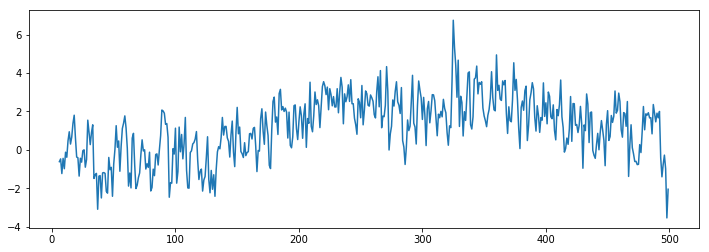

In [12]:
df.y.fracdiff(.7).plot(figsize=(12,4))
plt.show()

In [13]:
df.y.fracdiff(.7).ewm(alpha=0.1).mean().plot(figsize=(12,4))
plt.show()